# Stellar classification using machine learning models

Stars fascinate humanity since its beginning. It has played a very important role in our history, providing us with a cosmic callendar which proved itself crucial for activities such as agriculture.

Modern science has made significant discoveries about the nature of these celestial bodies. We now know that stars are mainly made of different elements clustered toghether in a hot plasma fueled by nuclear fusion reactions.

Very important to understand the evolution of a star during its lifecyle is its classification in a system called *Yerkes Spectral Classification*, introduced by William W. Morgan, Philip C. Keenan and Edith Kellman of the Yerkes Observatory.

In this project, the application of machine learning models for classification of stars will be studied utilizing data from the *Hipparcos Astronomical Catalogue*.

## Fetch data

To obtain data from the Hipparcos Catalogue, we use the PyVO package. It provides the interface to perform requests to archieves that uses the standard protocols developed by the Virtual Observatory (VO) initiative.

In [1]:
# Access astronomical databases
from pyvo import registry

We use PyVO to specifically access the Hipparcos Catalogue from VizieR. VizieR is a vast database of astronomical catalogues developed by the Strasbourg astronomical Data Center (CDS).

In [2]:
# the catalogue name in VizieR for the Hipparcos catalogue
CATALOGUE = "I/239"

# each resource in the VO has an identifier, called ivoid. For vizier catalogs,
# the VO ids can be constructed like this:
catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"
# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

We can get more information about the catalogue with the following line.

In [3]:
# We can print metadata information about the catalogue
voresource.describe(verbose=True)

The Hipparcos and Tycho Catalogues
Short Name: I/239
IVOA Identifier: ivo://cds.vizier/i/239
Access modes: conesearch, tap#aux, web
Multi-capability service -- use get_service()

The Hipparcos and Tycho Catalogues are the primary products of the European
Space Agency's astrometric mission, Hipparcos. The satellite, which operated
for four years, returned high quality scientific data from November 1989 to
March 1993. Each of the catalogues contains a large quantity of very high
quality astrometric and photometric data. In addition there are associated
annexes featuring variability and double/multiple star data, and solar system
astrometric and photometric measurements. In the case of the Hipparcos
Catalogue, the principal parts are provided in both printed and machine-
readable form (on CDROM). In the case of the Tycho Catalogue, results are
provided in machine-readable form only (on CDROM). Although in general only
the final reduced and calibrated astrometric and photometric data are
p

The Hipparcos Catalogue contains many tables which can be listed with the `get_tables()` method.

In [4]:
tables = voresource.get_tables()
tables

{'I/239/hip_main': <VODataServiceTable name="I/239/hip_main">... 81 columns ...</VODataServiceTable>,
 'I/239/h_dm_com': <VODataServiceTable name="I/239/h_dm_com">... 39 columns ...</VODataServiceTable>,
 'I/239/hip_dm_o': <VODataServiceTable name="I/239/hip_dm_o">... 19 columns ...</VODataServiceTable>,
 'I/239/hip_va_1': <VODataServiceTable name="I/239/hip_va_1">... 24 columns ...</VODataServiceTable>,
 'I/239/hip_va_2': <VODataServiceTable name="I/239/hip_va_2">... 22 columns ...</VODataServiceTable>,
 'I/239/solar_ha': <VODataServiceTable name="I/239/solar_ha">... 9 columns ...</VODataServiceTable>,
 'I/239/solar_hp': <VODataServiceTable name="I/239/solar_hp">... 10 columns ...</VODataServiceTable>,
 'I/239/solar_t': <VODataServiceTable name="I/239/solar_t">... 15 columns ...</VODataServiceTable>,
 'I/239/hd_notes': <VODataServiceTable name="I/239/hd_notes">... 7 columns ...</VODataServiceTable>,
 'I/239/hg_notes': <VODataServiceTable name="I/239/hg_notes">... 7 columns ...</VOData

The data we are interested in is in the main table (`I/239/hip_main`). As informed in the previous output, this table contains 81 columns. The following cell outputs the name of each of the columns.

In [5]:
sorted(c.name for c in tables["I/239/hip_main"].columns)

['(v-i)red',
 '_de.icrs',
 '_ra.icrs',
 'astroref',
 'b-v',
 'bd',
 'btmag',
 'ccdm',
 'chart',
 'cod',
 'combmag',
 'cpd',
 'de:ra',
 'dedms',
 'deicrs',
 'dhp',
 'e_b-v',
 'e_btmag',
 'e_deicrs',
 'e_dhp',
 'e_hpmag',
 'e_plx',
 'e_pmde',
 'e_pmra',
 'e_raicrs',
 'e_rho',
 'e_v-i',
 'e_vtmag',
 'erratum',
 'f1',
 'f2',
 'hd',
 'hip',
 'hipep',
 'hpmag',
 'hpmax',
 'hpmin',
 'hpscat',
 'hvartype',
 'm_btmag',
 'm_hip',
 'm_hpmag',
 'morephoto',
 'morevar',
 'multflag',
 'n_ccdm',
 'ncomp',
 'notes',
 'nsys',
 'o_hpmag',
 'period',
 'plx',
 'plx:de',
 'plx:ra',
 'pmde',
 'pmde:de',
 'pmde:plx',
 'pmde:pmra',
 'pmde:ra',
 'pmra',
 'pmra:de',
 'pmra:plx',
 'pmra:ra',
 'proxy',
 'qual',
 'r_b-v',
 'r_sptype',
 'r_v-i',
 'r_vmag',
 'rahms',
 'raicrs',
 'recno',
 'rho',
 'source',
 'sptype',
 'survey',
 'theta',
 'v-i',
 'varflag',
 'vmag',
 'vtmag']

Detailed description of the quantities reported in each column can be found directly in the [documentation](https://www.cosmos.esa.int/web/hipparcos/catalogues) of the Hipparcos Catalogue. For our goal of stellar classification, the following quantities were selected:

| Quantity         | Description                                                                                          | Column name
| ---------------- | ---------------------------------------------------------------------------------------------------- | ----------- 
| HIP ID           | Unique ID of the star in the Hipparcos Catalogue.                                                    | `hip`
| Parallax         | The apparent change in position of the star due to measurement at different points in Earth's orbit. | `plx`
| Visual magnitude | The apparent magnitude ("brightness") of the star as observed from Earth.                            | `vmag`
| Hp magnitude     | The apparent magnitude as measured in the Hipparcos system.                                          | `hpmag`
| B-V              | The color index of the star in the Johnson UBV system.                                               | `B-V`
| V-I              | The color index of the star in the Cousins' system.                                                  | `V-I`
| Spectral Type    | The spectral type of the star.                                                                       | `sptype`

To ensure the quality of the data, we also filter the results so that only observations with relative parallax error smaller than 0.2 milliarcsecs and uncertainty in B-V smaller or equal to 0.05 mag are selected.

To actually retrieve the data, a SQL-like query is sent through the pyVO interface using the `run_sync()` method. The result is then converted into a pandas dataframe. 

In [56]:
# build ADQL query to retrieve data
target_table_name = "I/239/hip_main"
target_columns = 'hip, plx, vmag, hpmag, "B-V", "V-I", sptype'
# cuts = 'plx > 0 AND e_plx/plx < 0.2 AND "e_V-I" <= 0.05' + " AND ccdm = ''"
cuts = 'plx > 0 AND e_plx/plx < 0.2 AND "e_B-V" <= 0.05'

query_text = f'SELECT {target_columns} FROM "{target_table_name}" WHERE {cuts}'

# execute a synchronous ADQL query
tap_records = voresource.get_service("tap").run_sync(query_text)

df = tap_records.to_table().to_pandas()
df

,HIP,Plx,Vmag,Hpmag,B-V,V-I,SpType
0,2,21.90,9.27,9.4017,0.999,1.04,K3V
1,4,7.75,8.06,8.1498,0.370,0.43,F0V
2,7,17.74,9.64,9.6795,0.740,0.79,G0
3,10,10.76,8.59,8.6994,0.489,0.56,F6V
4,11,4.29,7.34,7.3777,0.081,0.09,A2
...,...,...,...,...,...,...,...
47739,118312,7.22,8.35,8.4901,0.724,0.78,G5
47740,118311,24.63,11.85,11.9884,1.391,1.65,
47741,118319,10.63,8.23,8.3699,0.639,0.70,G2V
47742,118321,19.22,9.20,9.3312,0.698,0.75,G5V


## Clean data

In [8]:
len(df["SpType"].unique())

2013

In [9]:
for i in df["SpType"].unique():
    print(i)

K3V
F0V
G0
F6V
A2
K0
F3V
G5
K2
F2V
G0V
G3IV
F7V
G5V
F3/F5V
F2
F7.5IV-V
G6V
G9III-IV
G1IV
A4V
M:
G2IV/V
K2V
F2IV
K5
B9p SiEu

F5
A0
G3/G5V
G2V
G8III
F5IV/V
F8V
G2
F5V
F0
G7II-III
M2III
M2
M1.5V:
G0IV
A2IV
K2III
Am...
F8
K2III-IV
K3
B7III-IV
K1III
F3IV...
M3III
K0III
A3
G9III
G3V
M0V
B4V
A6V
M3
F6/F7V
G8IV
F2/F3V
M1
A5
F8/G0V
G8V
B9IVn
M4
G5IV
M0
F0III/IV
G2/G3V
A1V
K0V
G3/G5III/IV
K0/K1III
B8III
F5IV
K4IIIb
G9V
G8II
G9III:
B8MNp...
A1Vn
K5V
B9
G8III/IV
M2V
A1Vs
G5III
K0...
K1III-IV
G1IV...
G1V
B9III
K1
F4IVws
A9V
F5IV-V
A2IV/V
K1IV
A6:m...
K1/K2III
B8IIIsp...
A3V
G8III:
B9p
G3/G5IV/V
F8IV
A4Vm
G4IV...
F3IV/V
F2III-IV
G2III
A7IV
G8/K0V
K1/K2V
K1V
K1IV/V
K1II
A2V
B9V
K3III
A
B7IV
K4III
F7IV
F3/F5IV+...
M2V:
K7
G6/G8V
G4V
F8...
K0p...
G5IV/V
K0V+...
G8/K0III
B2IV
M0/M1III
G0III
F0IV
A5IV
K1IIICNIV
M4III:
F4V
K0/K1VCN...
G1/G2V
M3IIIvar
M1III
A7III
A1p
F3IV
A8V
G8III...
B9Vn
G
G8II-III
A3...
B6III/IV
F3III
G1Vw...
K0III-IV
B7III
G5IV-V
K:
K0/K1IV/V:
A8IV
K0:Ib
K0II
F9V
G9
G8/K0IV/V
M1V
A0IV

In [10]:
df_clean = df.copy()

chars_exclude = [":", "+", "/", "...", "-", "Del"]

for char in chars_exclude:
    df_clean = df_clean[~(df_clean["SpType"].str.contains(char, regex=False))]

In [11]:
df_clean["SpType"].unique()

array(['K3V', 'F0V', 'G0', 'F6V', 'A2', 'K0', 'F3V', 'G5', 'K2', 'F2V',
       'G0V', 'G3IV', 'F7V', 'G5V', 'F2', 'G6V', 'G1IV', 'A4V', 'K2V',
       'F2IV', 'K5', 'B9p SiEu', '', 'F5', 'A0', 'G2V', 'G8III', 'F8V',
       'G2', 'F5V', 'F0', 'M2III', 'M2', 'G0IV', 'A2IV', 'K2III', 'F8',
       'K3', 'K1III', 'M3III', 'K0III', 'A3', 'G9III', 'G3V', 'M0V',
       'B4V', 'A6V', 'M3', 'G8IV', 'M1', 'A5', 'G8V', 'B9IVn', 'M4',
       'G5IV', 'M0', 'A1V', 'K0V', 'B8III', 'F5IV', 'K4IIIb', 'G9V',
       'G8II', 'A1Vn', 'K5V', 'B9', 'M2V', 'A1Vs', 'G5III', 'G1V',
       'B9III', 'K1', 'F4IVws', 'A9V', 'K1IV', 'A3V', 'B9p', 'F8IV',
       'A4Vm', 'G2III', 'A7IV', 'K1V', 'K1II', 'A2V', 'B9V', 'K3III', 'A',
       'B7IV', 'K4III', 'F7IV', 'K7', 'G4V', 'B2IV', 'G0III', 'F0IV',
       'A5IV', 'K1IIICNIV', 'F4V', 'M3IIIvar', 'M1III', 'A7III', 'A1p',
       'F3IV', 'A8V', 'B9Vn', 'G', 'F3III', 'B7III', 'A8IV', 'K0II',
       'F9V', 'G9', 'M1V', 'A0IV', 'B8V', 'K7V', 'A0Vs', 'B7V', 'K5III',
       'F5I

In [12]:
mask = df_clean["SpType"].str.contains("I", regex=False)
interest_char_list = ["V", "sd", "D"]
for char in interest_char_list:
    mask = mask | df_clean["SpType"].str.contains(char, regex=False)
df_clean = df_clean[mask]

In [13]:
df_clean["SpType"].unique()

array(['K3V', 'F0V', 'F6V', 'F3V', 'F2V', 'G0V', 'G3IV', 'F7V', 'G5V',
       'G6V', 'G1IV', 'A4V', 'K2V', 'F2IV', 'G2V', 'G8III', 'F8V', 'F5V',
       'M2III', 'G0IV', 'A2IV', 'K2III', 'K1III', 'M3III', 'K0III',
       'G9III', 'G3V', 'M0V', 'B4V', 'A6V', 'G8IV', 'G8V', 'B9IVn',
       'G5IV', 'A1V', 'K0V', 'B8III', 'F5IV', 'K4IIIb', 'G9V', 'G8II',
       'A1Vn', 'K5V', 'M2V', 'A1Vs', 'G5III', 'G1V', 'B9III', 'F4IVws',
       'A9V', 'K1IV', 'A3V', 'F8IV', 'A4Vm', 'G2III', 'A7IV', 'K1V',
       'K1II', 'A2V', 'B9V', 'K3III', 'B7IV', 'K4III', 'F7IV', 'G4V',
       'B2IV', 'G0III', 'F0IV', 'A5IV', 'K1IIICNIV', 'F4V', 'M3IIIvar',
       'M1III', 'A7III', 'F3IV', 'A8V', 'B9Vn', 'F3III', 'B7III', 'A8IV',
       'K0II', 'F9V', 'M1V', 'A0IV', 'B8V', 'K7V', 'A0Vs', 'B7V', 'K5III',
       'F5III', 'A0V', 'A9III', 'B9IV', 'G2IV', 'A7V', 'C6II', 'M5III',
       'A2Vs', 'A9IV', 'F6Vawvar', 'M0III', 'G4III', 'B9IIIn', 'F2III',
       'K0IV', 'B6V', 'B8Vn', 'B9.5V', 'F6III', 'A0Vn', 'G2V comp SB',
 

In [14]:
import numpy as np

df_clean["LumType"] = np.NaN
df_clean["SpType_cp"] = df_clean["SpType"]

replace_sequence = ["IV", "V", "III", "II", "I", "sd", "D"]
class_code = [3, 4, 2, 1, 0, 5, 6]

for seq, code in zip(replace_sequence, class_code):
    df_clean.loc[df_clean["SpType_cp"].str.contains(seq), "LumType"] = code
    df_clean.loc[df_clean["SpType_cp"].str.contains(seq), "SpType_cp"] = f"{code}"
df_clean = df_clean.drop(columns="SpType_cp")

In [15]:
df_clean

,HIP,Plx,Vmag,Hpmag,B-V,V-I,SpType,LumType
0,2,21.90,9.27,9.4017,0.999,1.04,K3V,4.0
1,4,7.75,8.06,8.1498,0.370,0.43,F0V,4.0
3,10,10.76,8.59,8.6994,0.489,0.56,F6V,4.0
6,17,6.15,8.15,8.2405,0.425,0.49,F3V,4.0
10,23,12.21,7.57,7.6626,0.456,0.53,F2V,4.0
...,...,...,...,...,...,...,...,...
47735,118301,5.54,7.67,7.7548,0.337,0.39,F2V,4.0
47736,118306,5.78,7.28,7.4445,1.044,1.01,K0III,2.0
47741,118319,10.63,8.23,8.3699,0.639,0.70,G2V,4.0
47742,118321,19.22,9.20,9.3312,0.698,0.75,G5V,4.0


In [16]:
df_clean.isna().sum()

HIP        0
Plx        0
Vmag       0
Hpmag      0
B-V        0
V-I        0
SpType     0
LumType    0
dtype: int64

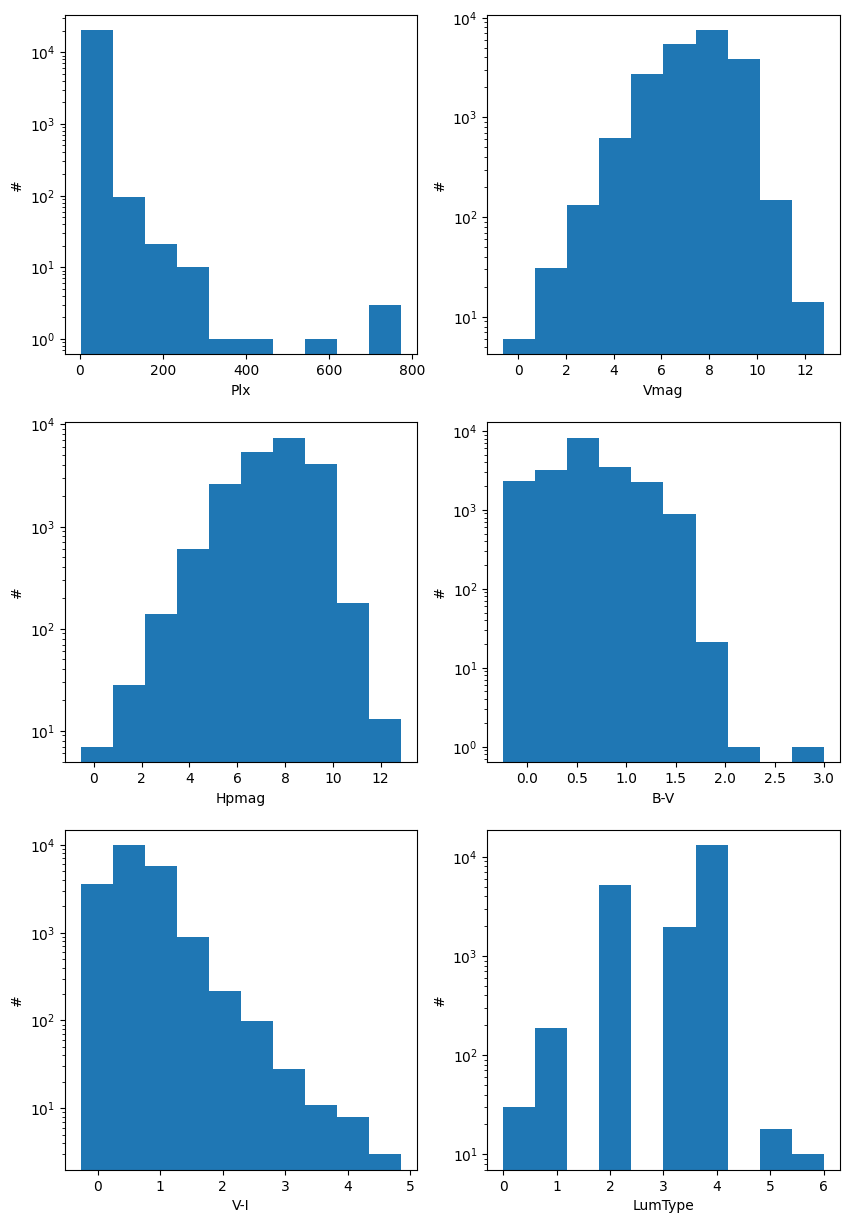

In [17]:
import matplotlib.pyplot as plt

fig_hists, ax_hists = plt.subplots(3, 2, figsize=(2*5, 3*5))

column_names = ("Plx", "Vmag", "Hpmag", "B-V", "V-I", "LumType")
for ax, col in zip(ax_hists.flat, column_names):
    ax.hist(df_clean[col])
    ax.set_yscale("log")
    ax.set(xlabel=col, ylabel="#")

### Derive some important quantities

In [18]:
def get_ab_mag(df, col):
    return df[col] - 5*(np.log10(1000/df["Plx"]) - 1)

In [19]:
df_clean["Abmag_hp"] = get_ab_mag(df_clean, "Hpmag")
df_clean["Abmag_v"] = get_ab_mag(df_clean, "Vmag")

In [20]:
df_clean

,HIP,Plx,Vmag,Hpmag,B-V,V-I,SpType,LumType,Abmag_hp,Abmag_v
0,2,21.90,9.27,9.4017,0.999,1.04,K3V,4.0,6.103921,5.972221
1,4,7.75,8.06,8.1498,0.370,0.43,F0V,4.0,2.596309,2.506509
3,10,10.76,8.59,8.6994,0.489,0.56,F6V,4.0,3.858461,3.749061
6,17,6.15,8.15,8.2405,0.425,0.49,F3V,4.0,2.184876,2.094376
10,23,12.21,7.57,7.6626,0.456,0.53,F2V,4.0,3.096178,3.003578
...,...,...,...,...,...,...,...,...,...,...
47735,118301,5.54,7.67,7.7548,0.337,0.39,F2V,4.0,1.472349,1.387549
47736,118306,5.78,7.28,7.4445,1.044,1.01,K0III,2.0,1.254139,1.089639
47741,118319,10.63,8.23,8.3699,0.639,0.70,G2V,4.0,3.502566,3.362666
47742,118321,19.22,9.20,9.3312,0.698,0.75,G5V,4.0,5.749967,5.618767


## Exploratory data analysis

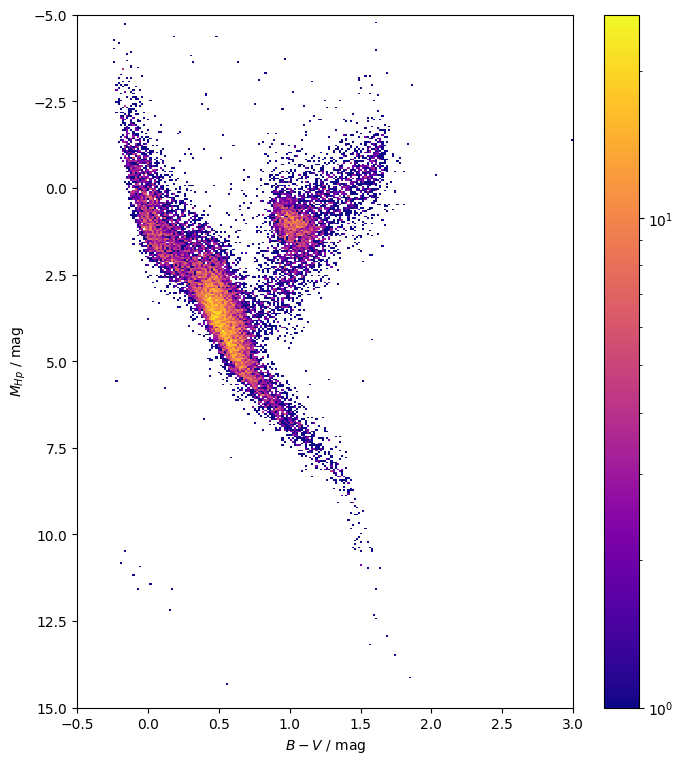

In [21]:
y_lims = [-5, 15]
x_lims = [-0.5, 3.0]
dy = 0.05
dx = 0.015
bins_x = int((x_lims[1] - x_lims[0]) / dx)
bins_y = int((y_lims[1] - y_lims[0]) / dy)

fig, ax = plt.subplots(figsize=(8, 9))

_, _, _, cbar = ax.hist2d(df_clean["B-V"], df_clean["Abmag_hp"], bins=(bins_x, bins_y), range=[x_lims, y_lims], cmap="plasma", norm="log")
ax.invert_yaxis()
ax.set_ylabel("$M_{Hp}$ / mag")
ax.set_xlabel("$B-V$ / mag")

_ = fig.colorbar(cbar, ax=ax)

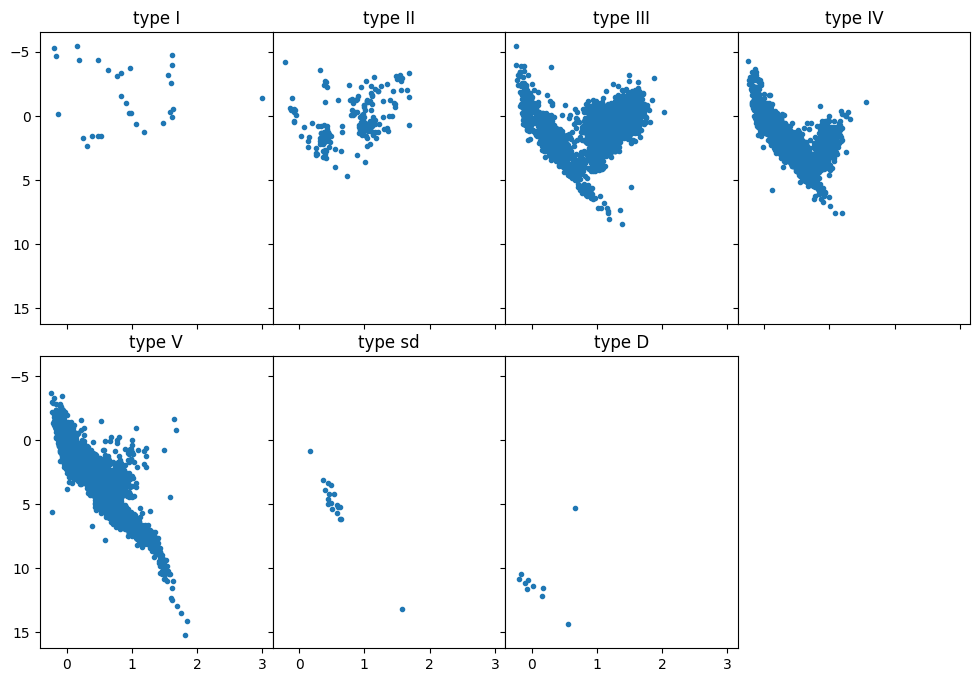

In [22]:
fig_types, ax_types = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(4*3, 2*4), gridspec_kw={"wspace":0, "hspace":0.11})

labels = ["I", "II", "III", "IV", "V", "sd", "D"]

for t, axs in zip(range(8), ax_types.flat):
    if t == 7:
        axs.set_axis_off()
        break
    df_type = df_clean[df_clean["LumType"] == t]
    axs.plot(df_type["B-V"], df_type["Abmag_hp"], ".")
    axs.set_title(f"type {labels[t]}")
    axs.invert_yaxis()

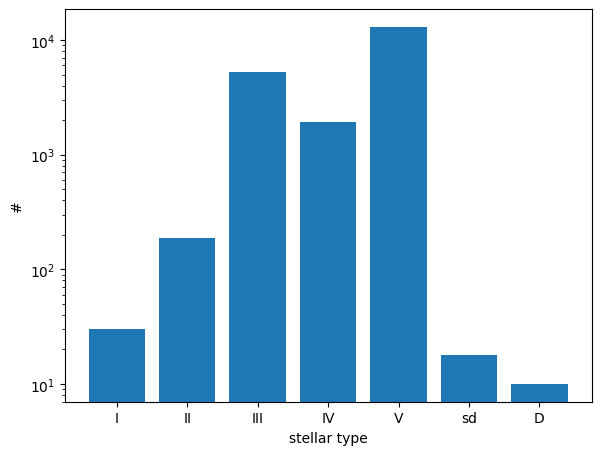

In [23]:
fig_h, ax_h = plt.subplots(figsize=(1.7*4, 1.7*3))

counts = []
for t in range(7):
    counts.append(len(df_clean[df_clean["LumType"] == t]))

ax_h.bar(labels, counts)
ax_h.set(ylabel="#", xlabel="stellar type")
ax_h.set_yscale("log")

In [24]:
corr = df_clean.drop(columns="SpType").corr()
corr.style.background_gradient(cmap="Reds").format(precision=2)

,HIP,Plx,Vmag,Hpmag,B-V,V-I,LumType,Abmag_hp,Abmag_v
HIP,1.00,0.02,-0.02,-0.02,0.02,0.02,0.00,0.02,0.02
Plx,0.02,1.00,-0.07,-0.06,0.10,0.14,0.19,0.45,0.45
Vmag,-0.02,-0.07,1.00,1.00,0.06,0.07,0.40,0.71,0.71
Hpmag,-0.02,-0.06,1.00,1.00,0.08,0.09,0.38,0.72,0.72
B-V,0.02,0.10,0.06,0.08,1.00,0.96,-0.54,0.09,0.07
V-I,0.02,0.14,0.07,0.09,0.96,1.00,-0.48,0.11,0.10
LumType,0.00,0.19,0.40,0.38,-0.54,-0.48,1.00,0.53,0.55
Abmag_hp,0.02,0.45,0.71,0.72,0.09,0.11,0.53,1.00,1.00
Abmag_v,0.02,0.45,0.71,0.72,0.07,0.10,0.55,1.00,1.00


## Data preprocessing for modeling

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [26]:
drop_columns = ["HIP", "SpType"]
df_clean = df_clean.drop(columns=drop_columns)
df_clean

,Plx,Vmag,Hpmag,B-V,V-I,LumType,Abmag_hp,Abmag_v
0,21.90,9.27,9.4017,0.999,1.04,4.0,6.103921,5.972221
1,7.75,8.06,8.1498,0.370,0.43,4.0,2.596309,2.506509
3,10.76,8.59,8.6994,0.489,0.56,4.0,3.858461,3.749061
6,6.15,8.15,8.2405,0.425,0.49,4.0,2.184876,2.094376
10,12.21,7.57,7.6626,0.456,0.53,4.0,3.096178,3.003578
...,...,...,...,...,...,...,...,...
47735,5.54,7.67,7.7548,0.337,0.39,4.0,1.472349,1.387549
47736,5.78,7.28,7.4445,1.044,1.01,2.0,1.254139,1.089639
47741,10.63,8.23,8.3699,0.639,0.70,4.0,3.502566,3.362666
47742,19.22,9.20,9.3312,0.698,0.75,4.0,5.749967,5.618767


In [27]:
y = df_clean.loc[:,"LumType"].to_numpy()
x = df_clean.drop(columns="LumType").values

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [29]:
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)

## Model training

In [30]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

models = [
    RandomForestClassifier(class_weight="balanced"),
    GradientBoostingClassifier(),
    LogisticRegression(class_weight="balanced", max_iter=500),
    DecisionTreeClassifier(class_weight="balanced"),
    SVC(class_weight="balanced", probability=True),
    MLPClassifier(hidden_layer_sizes=(32, 64, 32))
    ]
model_names = ["random forest", "gradient boosting", "logistic regression", "decision tree", "SVM", "neural network"]

for model in models:
    model.fit(x_train_sc, y_train)

/home/allan/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Model evaluation

In [43]:
preds = [model.predict(x_test_sc) for model in models]

In [44]:
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay

Plot the accuracy presented by each model.

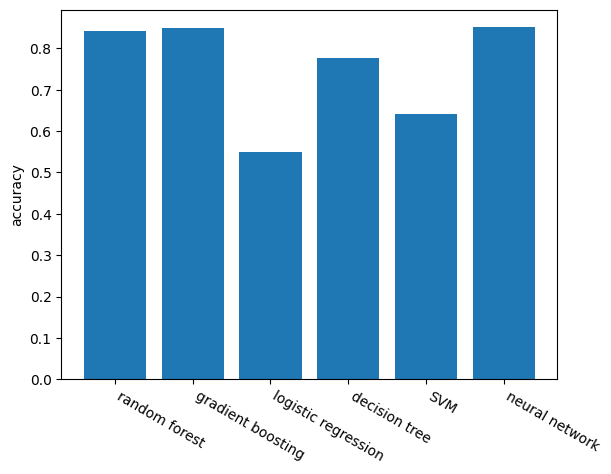

In [54]:
accu = [accuracy_score(y_test, pred) for pred in preds]

fig_accu, ax_accu = plt.subplots()

ax_accu.bar(model_names, accu)
ax_accu.set_ylabel("accuracy")
_ = ax_accu.set_xticks(range(len(model_names)), model_names, rotation=-30, ha="left")

Plot the confusion matrix normalized over the predicted label (columns), which provides the precision of the model for each stellar type.

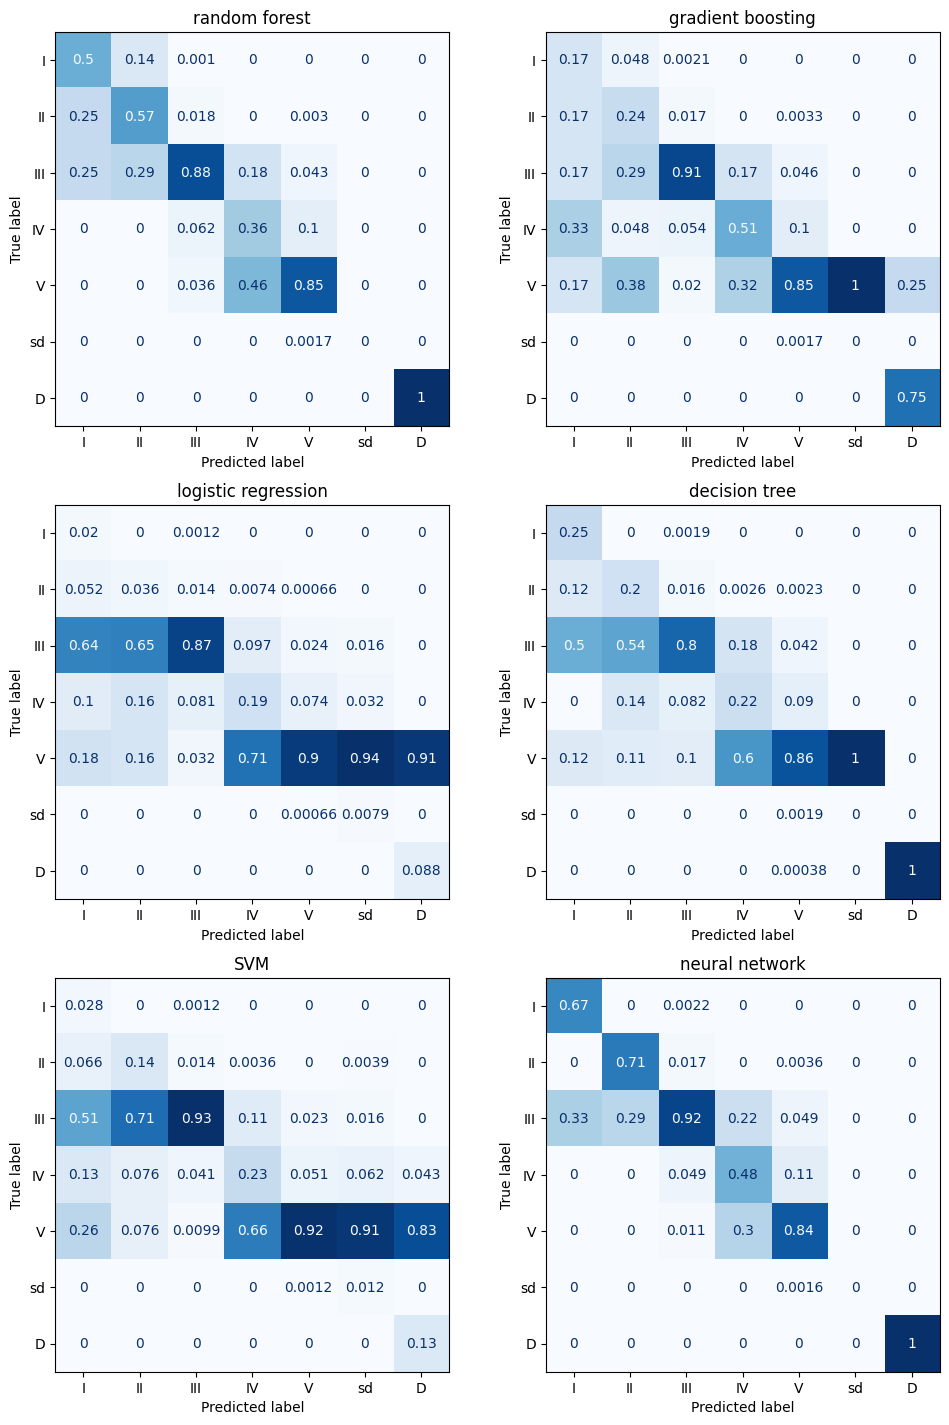

In [46]:
fig_cmp, ax_cmp = plt.subplots(3,2, figsize=(2*5.8, 3*5.8))

for ax, pred, model_name in zip(ax_cmp.flat, preds, model_names):
    ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=labels, normalize="pred", cmap="Blues", ax=ax, colorbar=False)
    ax.set_title(model_name)

Plot the confusion matrix normalized over the true label (rows), which provides the recall of the model for each stellar type.

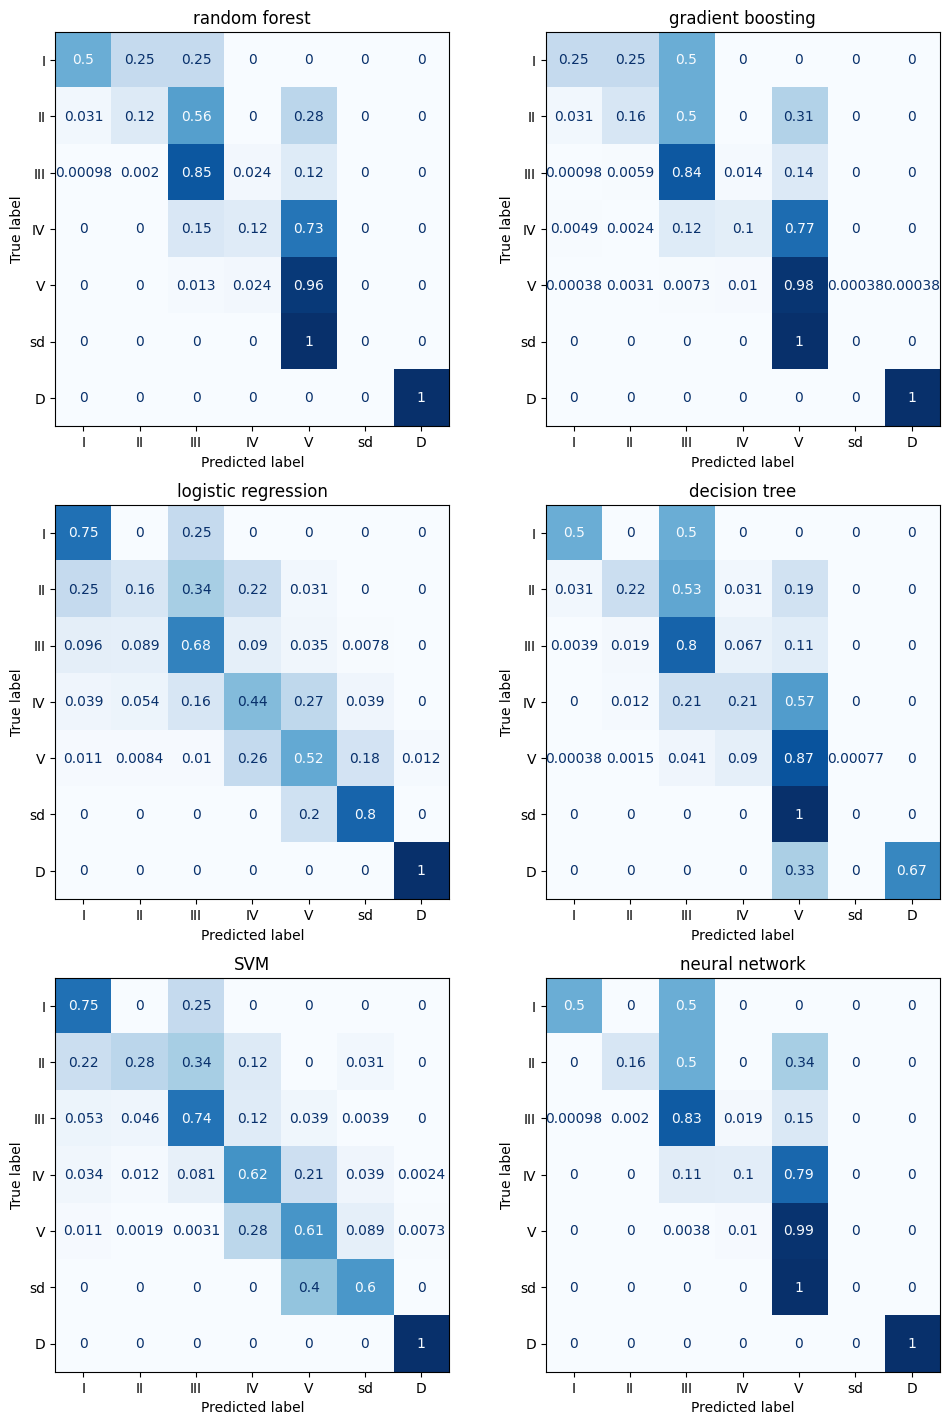

In [47]:
fig_cmp, ax_cmp = plt.subplots(3,2, figsize=(2*5.8, 3*5.8))

for ax, pred, model_name in zip(ax_cmp.flat, preds, model_names):
    ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=labels, normalize="true", cmap="Blues", ax=ax, colorbar=False)
    ax.set_title(model_name)

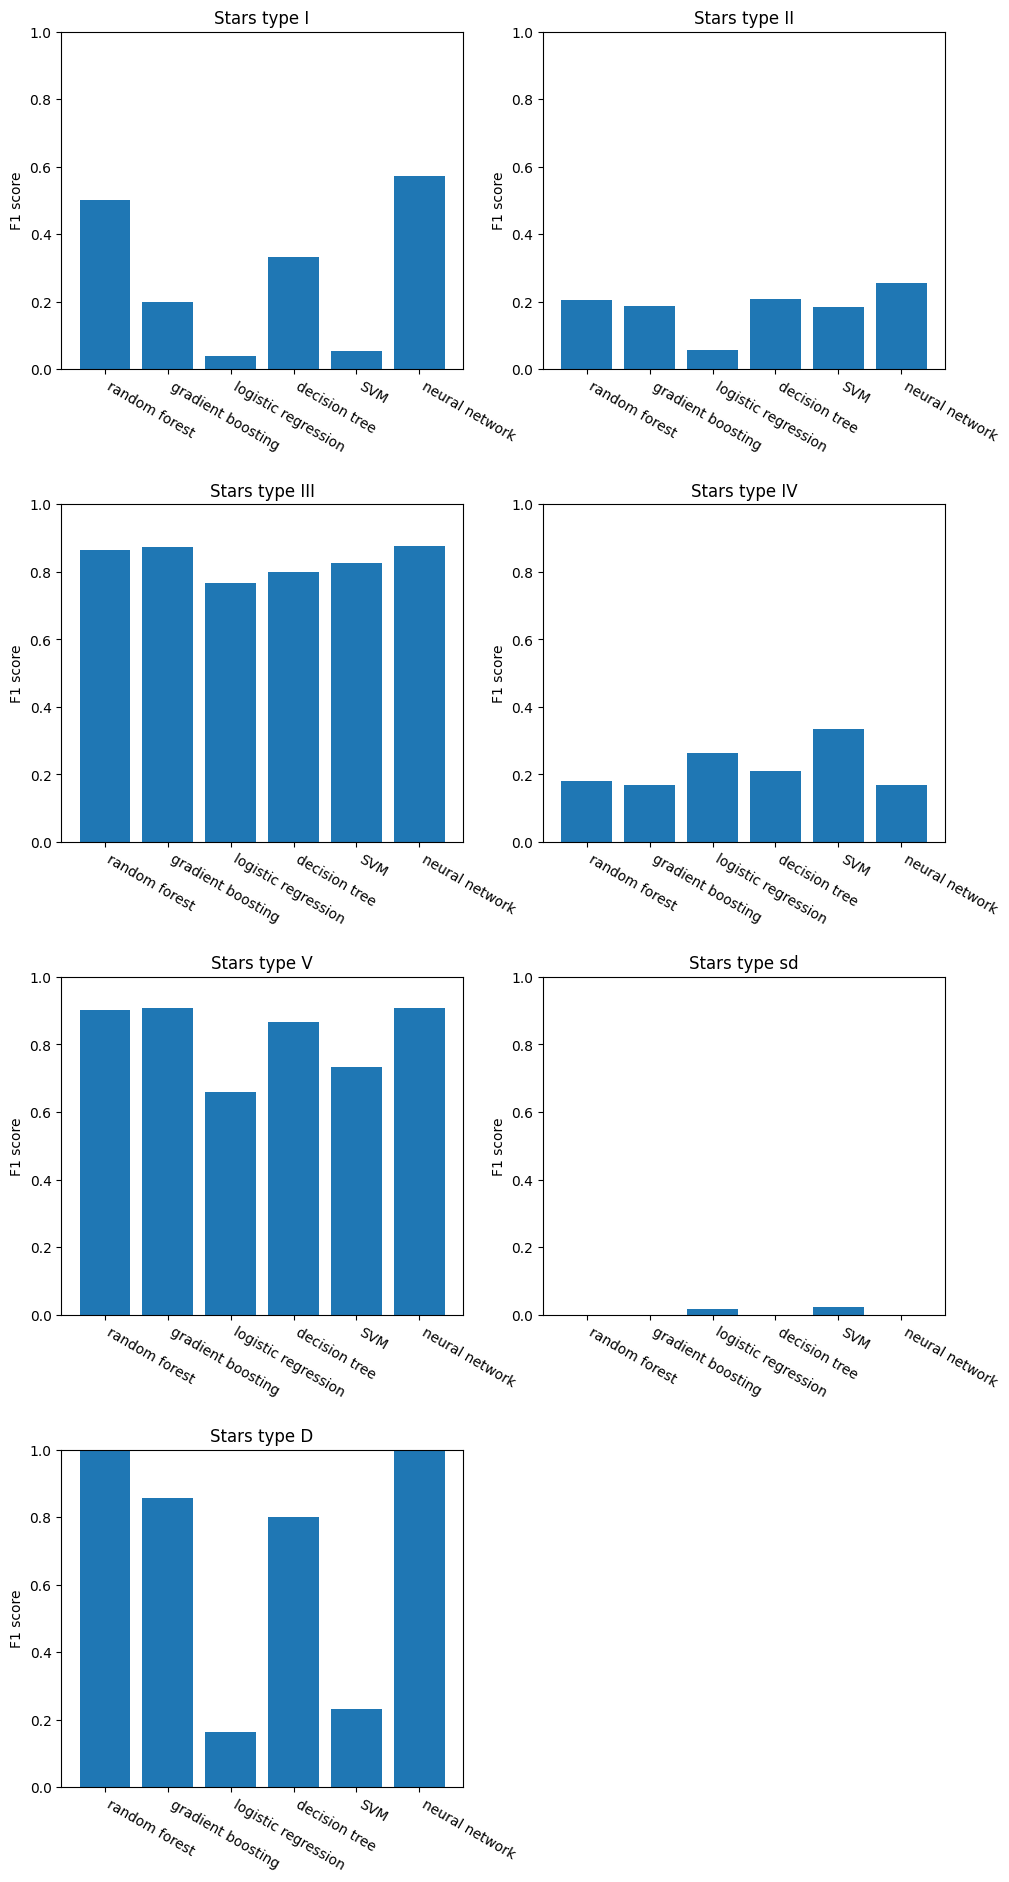

In [55]:
fig_f1, ax_f1 = plt.subplots(4, 2, figsize=(2*5.7, 4*5.7), gridspec_kw={"hspace":0.4})

f1_scores = [f1_score(y_test, pred, average=None) for pred in preds]

for stellar_type, ax, label in zip(range(7), ax_f1.flat, labels):
    type_f1_scores = [f1_scores[m][stellar_type] for m in range(len(models))]
    ax.bar(model_names, type_f1_scores)
    ax.set_xticks(range(len(model_names)), model_names, rotation=-30, ha="left")
    ax.set(ylabel="F1 score", title=f"Stars type {label}")
    ax.set_ylim(0, 1)

_ = ax_f1.flat[-1].set_axis_off()

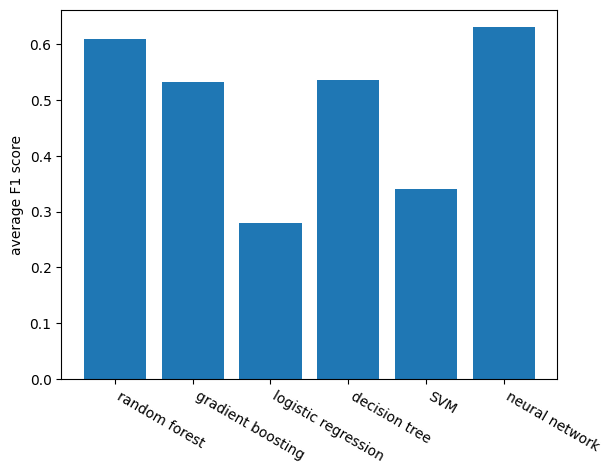

In [50]:
avg_f1_score = [f1_score(y_test, pred, average="macro", zero_division=np.nan) for pred in preds]

fig_avg_f1, ax_avg_f1 = plt.subplots()

ax_avg_f1.bar(model_names, avg_f1_score)
ax_avg_f1.set_ylabel("average F1 score")
_ = ax_avg_f1.set_xticks(range(len(model_names)), model_names, rotation=-30, ha="left")

In [51]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(4088, 7)

In [52]:
y_onehot_test

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

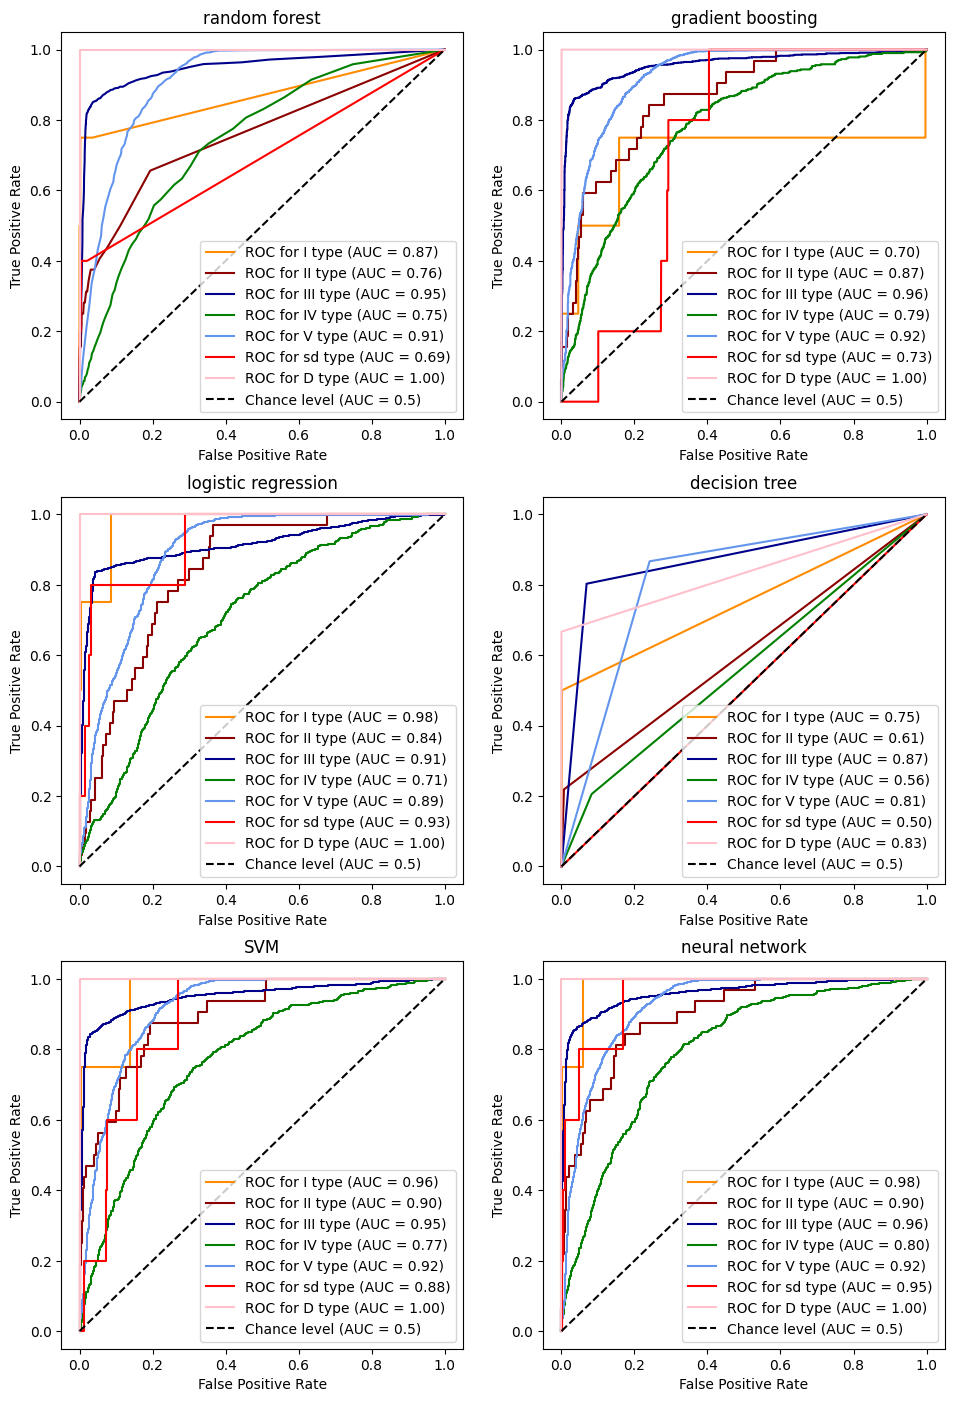

In [53]:
from sklearn.metrics import RocCurveDisplay

fig_roc, ax_roc = plt.subplots(3, 2, figsize=(2*5.7, 3*5.7))
colors = ("darkorange", "darkred", "darkblue", "green", "cornflowerblue", "red", "pink")

for model, model_name, ax in zip(models, model_names, ax_roc.flat):
    y_score = model.predict_proba(x_test_sc)
    for stellar_type, label, color in zip(range(7), labels, colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, stellar_type],
            y_score[:, stellar_type],
            name=f"ROC for {label} type",
            color=color,
            plot_chance_level=(stellar_type == 6),
            ax=ax
        )
    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=model_name,
    )